# Unprecedented_extreme_SkillOverview.ipynb

In [1]:
#!/usr/bin/env python
'''File name: Unprecedented_extreme_SkillOverview.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 16.04.2018
    Date last modified: 16.04.2018

    ############################################################## 
    Purpos:

    Apply the optimal settings for the region of interest that was
    determined with:
    ~/papers/Extreme-WTs-US/programs/Extreme-WTs/SearchOptimum_ExtremeEvent-WeatherTyping.py

    1) Read the FIRE and ERA-Interim data
    2) Get the 4 largest fire days in each subregion
    3) Exlude the year with the biggest fire year and build XWTs
    3) Calculate Eucledian Distances for each day in the excluded year
    4) Calculate the relative rank of the peak fire day according to its Euclidean Distance
    5) Plot an overview plot

'''

from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap; bm = Basemap()

from Functions_Extreme_WTs import XWT
from Functions_Extreme_WTs import MRR, MRD, perkins_skill
from Functions_Extreme_WTs import PreprocessWTdata

# !pip install adjustText

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])# ,axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

In [16]:
# ###################################################
# Get the setup for the XWTing
DW_Regions=['Bay_Area','Central_Coast','LA','Modoc','Northeast','San_Diego','Siearas_East','Siearas_West']
RegionNames = ['Bay Area','Central Coast','LA','Modoc','Northern','San Diego','Sierra East','Sierra West']

SortXWTs = [[1,0],
            [2,0,1],
            [0,1],
            [1,0],
            [2,1,0],
            [0,1],
            [1,0,2],
            [2,1,0]]

Season='Annual' # ['AMJJAS', 'ONDJFM']
iEvents = 4

RANKS_all = np.zeros((len(DW_Regions),iEvents)); RANKS_all[:] = np.nan
BurendArea_all = np.zeros((len(DW_Regions),iEvents)); BurendArea_all[:] = np.nan
ExtremeDay_asll = np.zeros((len(DW_Regions),iEvents), dtype='datetime64[s]'); ExtremeDay_asll[:]=""
ExtrDaysWT = np.zeros((len(DW_Regions),iEvents)); ExtrDaysWT[:] = np.nan

for re in range(len(DW_Regions)):
    iReg=re #int(sys.argv[1])
    sRegion=DW_Regions[re]
    print('    Process regions '+DW_Regions[re])
    Region=DW_Regions[iReg]
    rgsLableABC=list(string.ascii_lowercase)
    Domain=[38,-112,28,-121]

    from XWTs_apply_ERA5 import HUC2_XWTs_apply
    rgdTime, iMonths, sPlotDir, sDataDir, sSubregionPR, rgsWTvars, VarsFullName,rgsWTfolders, rgrNrOfExtremes, \
    WT_Domains, DomDegreeAdd, Annual_Cycle, SpatialSmoothing, Metrics, Dimensions,FireObs,REANAL,\
    ClusterMeth, ClusterBreakup, RelAnnom, NormalizeData, MinDistDD, RemoveAnnualCycl= HUC2_XWTs_apply(Season,Region)
    rgrNrOfExtremes=rgrNrOfExtremes #-1
    iNrOfExtremes=rgrNrOfExtremes
    sSubregionPR=sSubregionPR+Region
    YYYY_stamp='2001-2019'
    ss='-'
    VarsJoint=ss.join(VarsFullName)
    
    # read in the XWT clusters
#     XWTs='/glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/Clusters'+str(rgrNrOfExtremes+1)+'_'+DW_Regions[re]+'_2001-2019_'+'-'.join(rgsWTvars)+'_Annual_MODIS_ERA5'
    XWTs=sDataDir+'Clusters'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+VarsJoint+'_'+Season+'_'+\
    FireObs+'_'+REANAL+'_'+ClusterMeth+'_Breakup-'+str(ClusterBreakup)+'_RelAnnom-'+str(RelAnnom)+'_Norm-'+NormalizeData+\
    '_DDdist-'+str(MinDistDD)+'_RemAnnCyc-'+str(RemoveAnnualCycl)
    with open(XWTs, 'rb') as handle:
        npzfile = pickle.load(handle)
    grClustersFin=npzfile['grClustersFin']
    rgrClustersFin=grClustersFin['Full']

    # create nessesary directories
    if not os.path.exists(sDataDir):
        os.makedirs(sDataDir)
    if not os.path.exists(sPlotDir):
        os.makedirs(sPlotDir)
    sRegion=Region.replace('/','-')

    YYYY_stamp=str(rgdTime.year[0])+'-'+str(rgdTime.year[-1])
    ss='-'
    VarsJoint=ss.join(VarsFullName)
    sMonths=ss.join([str(iMonths[ii]) for ii in range(len(iMonths))])
    rgiSeasonWT=np.isin(rgdTime.month, iMonths)
    rgiYears=np.unique(rgdTime.year)
    rgdTime=rgdTime[rgiSeasonWT]
    SPLIT=np.where(rgdTime.year < rgiYears[int(len(rgiYears)/2)])[0][-1]
    rgdTimeMM = pd.date_range(datetime.datetime(rgdTime.year[0], rgdTime.month[0], rgdTime.day[0],0), end=datetime.datetime(rgdTime.year[-1], rgdTime.month[-1], rgdTime.day[-1],0), freq='m')

    sPlotDir=sPlotDir+sRegion+'/'
    if not os.path.exists(sPlotDir):
        os.makedirs(sPlotDir)

    print( str(rgrNrOfExtremes)+' EXTREMES')
    iNrOfExtremes=rgrNrOfExtremes   # we consider the N highest rainfall extremes

    # ###################################################
    #       READ IN SHAPEFILE
    ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/GriddedData/MODIS_BA_GLOBAL_1_2016_01_gridded.nc', mode='r') # open the netcdf file
    rgrLatPR=np.squeeze(ncid.variables['rlat'][:])
    rgrLonPR=np.squeeze(ncid.variables['rlon'][:])
    ncid.close()
    rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
    rgrSRactP=np.zeros((rgrLonPR.shape[0]*rgrLonPR.shape[1]))
    sf = shp.Reader(sSubregionPR)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
        rgrSRactP[TMP == 1]=1
    rgrSRactP=np.reshape(rgrSRactP, (rgrLatPR.shape[0], rgrLatPR.shape[1]))

    DomainSizes=['S','M','L','XXL']
    DomDegreeAdd=[2,5,10,20]
    DomDelta=DomDegreeAdd[DomainSizes.index(WT_Domains)]

    Wlon=ctr[:,0].min()
    Elon=ctr[:,0].max()
    Nlat=ctr[:,1].max()
    Slat=ctr[:,1].min()

    DomainWT=np.array([[Elon+DomDelta,Slat-DomDelta],
                       [Wlon-DomDelta,Slat-DomDelta],
                       [Wlon-DomDelta,Nlat+DomDelta],
                       [Elon+DomDelta,Nlat+DomDelta],
                       [Elon+DomDelta,Slat-DomDelta]])
    grWTregion=mplPath.Path(DomainWT)


    # ###################################################
    #         Read the FIRE grid and data
    rgiSrPR=np.array(np.where(rgrSRactP == True))
    iLatMaxP=rgiSrPR[0,:].max()+1
    iLatMinP=rgiSrPR[0,:].min()
    iLonMaxP=rgiSrPR[1,:].max()+1
    iLonMinP=rgiSrPR[1,:].min()
    rgrPRdata=np.zeros((sum(rgiSeasonWT),iLatMaxP-iLatMinP,iLonMaxP-iLonMinP))

    # ###################################################
    #         Read the FIRE observations
    from Functions_Extreme_WTs import ExtremeDays
    MinDistDD=7 # two extremes should be at least 7 days appart
    if FireObs == 'MODIS':
        rgiSrPR=np.array(np.where(rgrSRactP == True))
        iLatMaxP=rgiSrPR[0,:].max()+1
        iLatMinP=rgiSrPR[0,:].min()
        iLonMaxP=rgiSrPR[1,:].max()+1
        iLonMinP=rgiSrPR[1,:].min()
        rgrPRdata=np.zeros((sum(rgiSeasonWT),iLatMaxP-iLatMinP,iLonMaxP-iLonMinP))

        for mo in range(len(rgdTimeMM)):
            rgiDD=np.where(((rgdTimeMM.year[mo] == rgdTime.year) & (rgdTime.month == rgdTimeMM.month[mo]) & np.isin(rgdTimeMM.month[mo], iMonths)))[0]
            ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/data_20020702/GriddedData/MODIS_BA_GLOBAL_1_'+str(rgdTimeMM.year[mo])+'_'+str("%02d" % rgdTimeMM.month[mo])+'_gridded.nc', mode='r')
            rgrPRdata[rgiDD,:,:]=np.squeeze(ncid.variables['BurnedArea'][:,iLatMinP:iLatMaxP,iLonMinP:iLonMaxP])
            ncid.close()
        rgrPRdata[rgrPRdata<0] = np.nan

        rgiSRgridcells=rgrSRactP[iLatMinP:iLatMaxP,iLonMinP:iLonMaxP].astype('int')
        rgrPRrecords=np.sum(rgrPRdata[:,(rgiSRgridcells==1)], axis=(1))
        rgiExtrTrain=ExtremeDays(rgrPRrecords,iNrOfExtremes,MinDistDD)
        rgiExtremeDays=rgdTime[rgiExtrTrain]
    elif FireObs == 'Parks':
        SheanDataDir='/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Sean_Parks/SubRegion_DailyBurnedArea/'
        FILE=SheanDataDir+DW_Regions[iReg]+'.txt'
        rgrPRrecords=np.array(pd.read_csv(FILE, delim_whitespace=True, header = None))[:,0]

        rgiExtrTrain=ExtremeDays(rgrPRrecords,iNrOfExtremes,MinDistDD)
        rgiExtremeDays=rgdTime[rgiExtrTrain]

    # ###################################################
    #         Read the ERA-Interim grid and data
    from Functions_Extreme_WTs import ReadERA5
    DailyVarsOrig, LonWT, LatWT=ReadERA5(grWTregion,        # shapefile with WTing region
                                         rgdTime,           # time period for WTing
                                         iMonths,           # list of months that should be considered
                                         rgsWTfolders,      # directories containing WT files
                                         rgsWTvars)         # netcdf variable names of WT variables

    # ###################################################
    #         Select and loop over the top 4 events
    rgiExtrTrainSel=rgiExtrTrain=ExtremeDays(rgrPRrecords, iEvents, MinDistDD)
    PeakEvents=rgdTime[rgiExtrTrainSel]
    YYYYpeak=np.unique(PeakEvents.year)
    ExtremeDay_asll[re,:] = PeakEvents
    # loop over the peak events
    for ev in range(len(PeakEvents)):
        print('            Work on '+str(PeakEvents[ev]))
        ExtremeDay_asll[re,ev] = PeakEvents[ev]
        Day = PeakEvents[ev]
        ExtremeYear = Day.year
        DayInYear = Day.timetuple().tm_yday

        # loop over split sample statistics
        TRAIN=(rgdTime.year != ExtremeYear)
        TEST=(rgdTime.year == ExtremeYear)
        XWT_output=XWT(DailyVarsOrig[TRAIN,:],
                    DailyVarsOrig[TEST,:],
                    rgrPRrecords[TRAIN],
                    rgrPRrecords[TEST],
                    rgdTime[TRAIN],
                    rgdTime[TEST],
                    iNrOfExtremes,
                    SpatialSmoothing,
                    ClusterMeth=ClusterMeth,
                    ClusterBreakup=ClusterBreakup,
                    RelAnnom=RelAnnom,
                    NormalizeData=NormalizeData,
                    MinDistDD=MinDistDD,
                    RemoveAnnualCycl=RemoveAnnualCycl)
        
        DayInYear = DayInYear
        EucledianDist_orig = XWT_output['EucledianDistAllWTs']
        ED_extr= EucledianDist_orig[:,:][DayInYear-1,:] #    XWT_output['grEucledianDist'][DayInYear-1]
        iRank=np.array([np.where(np.sort(EucledianDist_orig[:,ii]) == ED_extr[ii])[0] for ii in range(len(ED_extr))])
        RANKS_all[re,ev] = np.min((iRank/len(EucledianDist_orig[:,:]))*100.)
        BurendArea_all[re,ev] = rgrPRrecords[TEST][DayInYear-1]
#         SelWTs[ev] = XWTclusters[1][np.argmin((iRank/len(EucledianDist_orig[ddY,:])))]
        
        
#         ED_extr=XWT_output['grEucledianDist'][DayInYear-1]
#         iRank=np.where(np.sort(XWT_output['grEucledianDist']) == ED_extr)[0][0]
#         RANKS_all[re,ev] = (iRank/len(XWT_output['grEucledianDist']))*100.
#         BurendArea_all[re,ev] = rgrPRrecords[TEST][DayInYear-1]
        
        # assign the day to one of the defined XWTs
        DailyVarsEvalNorm=PreprocessWTdata(DailyVarsOrig[TEST,:],                  # WT data [time,lat,lon,var]
                                           RelAnnom=RelAnnom,                     # calculate relative anomalies [1-yes; 0-no]
                                           SmoothSigma=SpatialSmoothing,   # Smoothing stddev (Gaussian smoothing)
                                           RemoveAnnualCycl=RemoveAnnualCycl,             # remove annual cycle [1-yes; 0-no]
                                           NormalizeData=NormalizeData)                # normalize data [1-yes; 0-no]
        TarField = DailyVarsEvalNorm[DayInYear-1]
        from Functions_Extreme_WTs import EucledianDistance
        EucledianDist, Correlation =EucledianDistance(TarField[None,:],
                                                    rgrClustersFin)
        ExtrDaysWT[re,ev]=np.argmin(EucledianDist)+1
        
        if (DW_Regions[re] == 'San_Diego') & (ev == 0):
            # collect data for example plot
            rgrPRrecordsE=np.copy(rgrPRrecords)
            TESTE=np.copy(TEST)
            XWT_outputE=XWT_output
            sSubregionPRE=sSubregionPR
            


    Process regions Bay_Area
4 EXTREMES
        Read ERA-5 year: 2001
        Read ERA-5 year: 2002
        Read ERA-5 year: 2003
        Read ERA-5 year: 2004
        Read ERA-5 year: 2005
        Read ERA-5 year: 2006
        Read ERA-5 year: 2007
        Read ERA-5 year: 2008
        Read ERA-5 year: 2009
        Read ERA-5 year: 2010
        Read ERA-5 year: 2011
        Read ERA-5 year: 2012
        Read ERA-5 year: 2013
        Read ERA-5 year: 2014
        Read ERA-5 year: 2015
        Read ERA-5 year: 2016
        Read ERA-5 year: 2017
        Read ERA-5 year: 2018
        Read ERA-5 year: 2019
            Work on 2003-08-28 00:00:00
            Work on 2017-10-09 00:00:00
            Work on 2015-07-23 00:00:00
            Work on 2007-09-07 00:00:00
    Process regions Central_Coast
6 EXTREMES
        Read ERA-5 year: 2001
        Read ERA-5 year: 2002
        Read ERA-5 year: 2003
        Read ERA-5 year: 2004
        Read ERA-5 year: 2005
        Read ERA-5 year: 2006
     

        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Unprecendented_Extremes/Unpresedented_Extreme_Skill.pdf


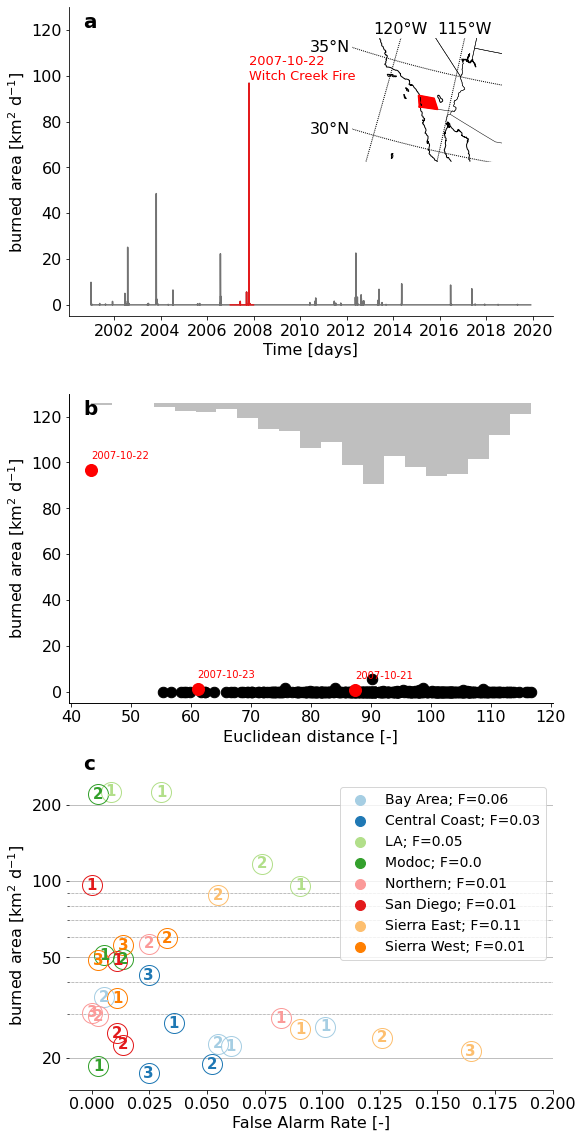

In [25]:
import matplotlib
COLORS=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(8,16))

gs1 = gridspec.GridSpec(3,1)
gs1.update(left=0.13, right=0.97,
           bottom=0.05, top=0.99,
           wspace=0.15, hspace=0.25)
# Timeline
ax = plt.subplot(gs1[0,0])
plt.plot(rgdTime,rgrPRrecordsE, c='#737373')
plt.plot(rgdTime[TESTE],rgrPRrecordsE[TESTE], c='#e31a1c')
ax.set_ylabel('burned area [km$^{2}$ d$^{-1}$]')
ax.set_xlabel('Time [days]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim((-5,130))
# Lable Which Creek Fire
DateWCF = rgdTime[np.argmax(rgrPRrecordsE)]
plt.text(DateWCF,np.max(rgrPRrecordsE), str(DateWCF).split(' ')[0]+'\nWitch Creek Fire', color='r',va='bottom', ha='left', fontsize=13)
ax.text(0.03,0.98, rgsLableABC[0] , ha='left',va='top', \
                 transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=20, weight='bold')
# plot map inlay
rect = [0.45,0.5,0.58,0.4]
axI = add_subplot_axes(ax,rect)
plt.axis('off')
m = Basemap(llcrnrlon=Domain[3],llcrnrlat=Domain[2],urcrnrlon=Domain[1],urcrnrlat=Domain[0], projection='lcc',
            lat_1=33,lat_2=45,lon_0=-95,resolution='i')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# highligth shape file
# m.readshapefile(sSubregionPR,'Houston_Harris_County_fin', drawbounds = False)
sf = shp.Reader(sSubregionPRE)
df = read_shapefile(sf)
for sf in range(df.shape[0]):
    ctr = df['coords'][sf]
    if len(ctr) > 10000:
        ctr=np.array(ctr)[::100,:] # corsen the shapefile accuracy
    else:
        ctr=np.array(ctr)
# add shapefile of catchment
XX,YY=m(ctr[:,0], ctr[:,1])
m.plot(XX,YY, c='r', lw=2)
axI.fill(XX,YY, c='r', alpha=1)

m.drawparallels(np.arange(-90.,120.,5.),labels=[True,False,True,False])
m.drawmeridians(np.arange(0.,360.,5.),labels=[True,False,True,False])

# Scatter Plot
ax = plt.subplot(gs1[1,0])
EventStartDay=datetime.datetime(2017, 8, 25,0)
day_of_year = EventStartDay.timetuple().tm_yday
EventDuration=5
plt.scatter(XWT_outputE['grEucledianDist'],rgrPRrecordsE[TESTE], s=110, cmap='coolwarm', c='k') #, vmin=mi, vmax=ma, c=PW_ERA[TEST]
for dd in range(3):
    jj=np.argmax(rgrPRrecordsE[TESTE])-1+dd
    ax.plot(XWT_outputE['grEucledianDist'][jj], rgrPRrecordsE[TESTE][jj], marker='o', markersize=12, color='r')
    DateWCF = rgdTime[TESTE][jj]
    ax.text(XWT_outputE['grEucledianDist'][jj], rgrPRrecordsE[TESTE][jj]+4, str(DateWCF).split(' ')[0], color='r', ha='left', va='bottom', fontsize=10)

ax.set_ylim((-5,130))
# ax.set_xlim((18,30.5))
ax.text(0.03,0.98, rgsLableABC[1] , ha='left',va='top', \
                 transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=20, weight='bold')

# add eucledian distance histrogram
import matplotlib.pyplot as plt
ax2 = ax.twinx()
ax2.hist(XWT_outputE['grEucledianDist'], bins=21, alpha=0.25, color='k')
# ax2.set_xlim(ax.get_xlim())
ax2.set_ylim((160,ax.get_ylim()[0]))
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.tick_params(axis='both', which='both', length=0)
ax.set_ylabel('burned area [km$^{2}$ d$^{-1}$]')
ax.set_xlabel('Euclidean distance [-]')
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)


#####################################################
# show skill as function of var. perturbation
# gs2 = gridspec.GridSpec(1,1)
# gs2.update(left=0.10, right=0.95,
#            bottom=0.08, top=0.50,
#            wspace=0.35, hspace=0.20)
ax = plt.subplot(gs1[2,0])

ax.set_xlabel('False Alarm Rate [-]')
ax.set_ylabel('burned area [km$^{2}$ d$^{-1}$]')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(axis='y')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


FAR = ((RANKS_all/100.)*365)/365.
for re in range(len(DW_Regions)):
    try:
        for ev in range(FAR.shape[1]):
            RE = SortXWTs[re][int(ExtrDaysWT[re,ev]-1)]
            ax.plot(FAR[re,ev], BurendArea_all[re,ev], marker='o', markersize = 20, color=COLORS[re], markerfacecolor="None")
            ax.text(FAR[re,ev], BurendArea_all[re,ev], str(int(RE+1)), color=COLORS[re], fontsize=15, weight="bold", va='center',ha='center')
        ax.plot(np.median(FAR[re,:]), 5, marker='|', markeredgewidth=3, markersize=10, color=COLORS[re])
        ax.scatter(-10, -10, color=COLORS[re], label=RegionNames[re]+'; F='+str(np.round(np.median(FAR[re,:]),2)), s=100)
    except:
        continue
ax.legend(fontsize=14)


ax.set_yscale('log')
from matplotlib.ticker import ScalarFormatter, NullFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())

ax.set_ylim((15,250))
ax.set_yticks([20,50,100,200])
# ax.set_xscale('log')
ax.set_xlim((-0.01,0.2))
ax.text(0.03,1.02, rgsLableABC[2] , ha='left',va='bottom', \
                 transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=20, weight='bold')

sPlotFile='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Unprecendented_Extremes/'
sPlotName= 'Unpresedented_Extreme_Skill.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)